<a href="https://colab.research.google.com/github/harsh-kmr/movie-prediction/blob/main/movie_recommendation_system.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from urllib.request import urlretrieve
import zipfile
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib Inline

In [2]:
print("Downloading movielens data...")


urlretrieve("http://files.grouplens.org/datasets/movielens/ml-100k.zip", "movielens.zip")
zip_ref = zipfile.ZipFile('movielens.zip', "r")
zip_ref.extractall()
print("Done. Dataset contains:")
print(zip_ref.read('ml-100k/u.info').decode(encoding='UTF-8'))

Done. Dataset contains:
943 users
1682 items
100000 ratings



In [3]:

#column names
users_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=users_cols,)
users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [4]:
ratings_cols = ['user_id', 'movie_id', 'rating', 'unix_timestamp']
ratings = pd.read_csv('ml-100k/u.data', sep='\t', names=ratings_cols)
ratings.head()

,user_id,movie_id,rating,unix_timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [5]:
genre_cols = [
    "genre_unknown", "Action", "Adventure", "Animation", "Children", "Comedy",
    "Crime", "Documentary", "Drama", "Fantasy", "Film-Noir", "Horror",
    "Musical", "Mystery", "Romance", "Sci-Fi", "Thriller", "War", "Western"
]
movies_cols = ['movie_id', 'title', 'release_date', "video_release_date", "imdb_url"] + genre_cols

movies = pd.read_csv('ml-100k/u.item', sep='|', names=movies_cols, encoding='latin-1')
movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [6]:
# Since the ids start at 1, we shift them to start at 0.
users["user_id"] = users["user_id"].apply(lambda x: x-1)
movies["movie_id"] = movies["movie_id"].apply(lambda x: x-1)
movies["year"] = movies['release_date'].apply(lambda x: str(x).split('-')[-1])
ratings["movie_id"] = ratings["movie_id"].apply(lambda x: x-1)
ratings["user_id"] = ratings["user_id"].apply(lambda x: (x-1))
ratings["rating"] = ratings["rating"].apply(lambda x: float(x))

In [7]:
genre_occurences = movies[genre_cols].sum().to_dict()

genre_occurences

{'genre_unknown': 2,
 'Action': 251,
 'Adventure': 135,
 'Animation': 42,
 'Children': 122,
 'Comedy': 505,
 'Crime': 109,
 'Documentary': 50,
 'Drama': 725,
 'Fantasy': 22,
 'Film-Noir': 24,
 'Horror': 92,
 'Musical': 56,
 'Mystery': 61,
 'Romance': 247,
 'Sci-Fi': 101,
 'Thriller': 251,
 'War': 71,
 'Western': 27}

In [8]:

def mark_genres(movies, genres):
  def get_random_genre(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return np.random.choice(active)
  def get_all_genres(gs):
    active = [genre for genre, g in zip(genres, gs) if g==1]
    if len(active) == 0:
      return 'Other'
    return '-'.join(active)
  movies['genre'] = [
      get_random_genre(gs) for gs in zip(*[movies[genre] for genre in genres])]
  movies['all_genres'] = [
      get_all_genres(gs) for gs in zip(*[movies[genre] for genre in genres])]

mark_genres(movies, genre_cols)

movies.head()

,movie_id,title,release_date,video_release_date,imdb_url,genre_unknown,Action,Adventure,Animation,Children,...,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western,year,genre,all_genres
0,0,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,1995,Animation,Animation-Children-Comedy
1,1,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,1,0,0,1995,Action,Action-Adventure-Thriller
2,2,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Thriller
3,3,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,1995,Action,Action-Comedy-Drama
4,4,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,1,0,0,1995,Thriller,Crime-Drama-Thriller


In [9]:
movielens = ratings.merge(movies, on='movie_id').merge(users, on='user_id')
movielens.head()

,user_id,movie_id,rating,unix_timestamp,title,release_date,video_release_date,imdb_url,genre_unknown,Action,...,Thriller,War,Western,year,genre,all_genres,age,sex,occupation,zip_code
0,195,241,3.0,881250949,Kolya (1996),24-Jan-1997,NaN,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,...,0,0,0,1997,Comedy,Comedy,49,M,writer,55105
1,195,256,2.0,881251577,Men in Black (1997),04-Jul-1997,NaN,http://us.imdb.com/M/title-exact?Men+in+Black+...,0,1,...,0,0,0,1997,Comedy,Action-Adventure-Comedy-Sci-Fi,49,M,writer,55105
2,195,110,4.0,881251793,"Truth About Cats & Dogs, The (1996)",26-Apr-1996,NaN,http://us.imdb.com/M/title-exact?Truth%20About...,0,0,...,0,0,0,1996,Romance,Comedy-Romance,49,M,writer,55105
3,195,24,4.0,881251955,"Birdcage, The (1996)",08-Mar-1996,NaN,"http://us.imdb.com/M/title-exact?Birdcage,%20T...",0,0,...,0,0,0,1996,Comedy,Comedy,49,M,writer,55105
4,195,381,4.0,881251843,"Adventures of Priscilla, Queen of the Desert, ...",01-Jan-1994,NaN,http://us.imdb.com/M/title-exact?Adventures%20...,0,0,...,0,0,0,1994,Comedy,Comedy-Drama,49,M,writer,55105


In [10]:
print(movielens.isnull().sum(),'\n', movielens.dtypes)

user_id                    0
movie_id                   0
rating                     0
unix_timestamp             0
title                      0
release_date               9
video_release_date    100000
imdb_url                  13
genre_unknown              0
Action                     0
Adventure                  0
Animation                  0
Children                   0
Comedy                     0
Crime                      0
Documentary                0
Drama                      0
Fantasy                    0
Film-Noir                  0
Horror                     0
Musical                    0
Mystery                    0
Romance                    0
Sci-Fi                     0
Thriller                   0
War                        0
Western                    0
year                       0
genre                      0
all_genres                 0
age                        0
sex                        0
occupation                 0
zip_code                   0
dtype: int64 


we can drop "video_release_date"

In [11]:
len(movielens[movielens['year']=='nan'])

9

In [12]:
movielens.drop(columns='video_release_date', inplace=True)
movielens['year'] = movielens['year'].apply(lambda x:int(x) if x != 'nan' else 0)
movielens['sex'] = movielens['sex'].apply(lambda x: 1 if x == 'M' else 0)

In [13]:
obj_col = list(movielens.select_dtypes(['object']).columns)
obj_col

['title',
 'release_date',
 'imdb_url',
 'genre',
 'all_genres',
 'occupation',
 'zip_code']

<Figure size 1600x1600 with 0 Axes>

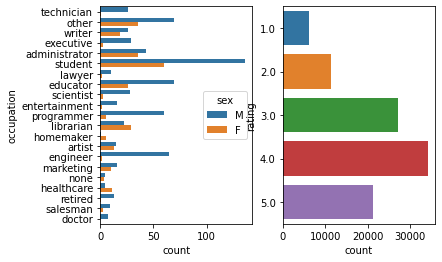

In [14]:
plt.figure(figsize=(20,20),dpi=80)
f, axes = plt.subplots(1, 2)
sns.countplot(y='occupation', data= users, hue='sex', ax=axes[0])
sns.countplot(data=ratings,y ='rating', ax= axes[1])


In [15]:
xyz = ratings.groupby('movie_id', as_index=False).agg({'rating': ['count', 'mean']})
xyz['movie_name'] = movies[movies['movie_id'] == xyz['movie_id']]['title']
xyz.columns = xyz.columns.to_series().apply(lambda x: ''.join(x))
xyz.sort_values('ratingcount', ascending=False).head(10) 

,movie_id,ratingcount,ratingmean,movie_name
49,49,583,4.358491,Star Wars (1977)
257,257,509,3.803536,Contact (1997)
99,99,508,4.155512,Fargo (1996)
180,180,507,4.007890,Return of the Jedi (1983)
293,293,485,3.156701,Liar Liar (1997)
285,285,481,3.656965,"English Patient, The (1996)"
287,287,478,3.441423,Scream (1996)
0,0,452,3.878319,Toy Story (1995)
299,299,431,3.631090,Air Force One (1997)
120,120,429,3.438228,Independence Day (ID4) (1996)


In [16]:
xyz.sort_values('ratingmean', ascending=False).head(10) 

,movie_id,ratingcount,ratingmean,movie_name
813,813,1,5.0,"Great Day in Harlem, A (1994)"
1598,1598,1,5.0,Someone Else's America (1995)
1200,1200,1,5.0,Marlene Dietrich: Shadow and Light (1996)
1121,1121,1,5.0,They Made Me a Criminal (1939)
1652,1652,1,5.0,Entertaining Angels: The Dorothy Day Story (1996)
1292,1292,3,5.0,Star Kid (1997)
1499,1499,2,5.0,Santa with Muscles (1996)
1188,1188,3,5.0,Prefontaine (1997)
1535,1535,1,5.0,Aiqing wansui (1994)
1466,1466,2,5.0,"Saint of Fort Washington, The (1993)"


In [17]:
xyz['ratingcount'] = xyz['ratingcount'].where(lambda x: x>20)
xyz.dropna(inplace=True)
xyz.sort_values('ratingmean', ascending=False).head()

,movie_id,ratingcount,ratingmean,movie_name
407,407,112.0,4.491071,"Close Shave, A (1995)"
317,317,298.0,4.466443,Schindler's List (1993)
168,168,118.0,4.466102,"Wrong Trousers, The (1993)"
482,482,243.0,4.456790,Casablanca (1942)
113,113,67.0,4.447761,Wallace & Gromit: The Best of Aardman Animatio...


<Figure size 1600x1600 with 0 Axes>

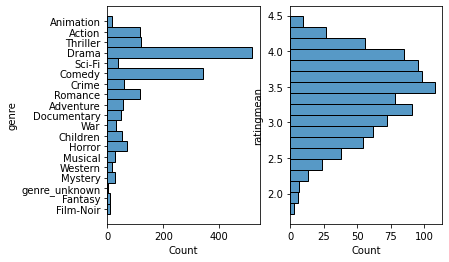

In [18]:
plt.figure(figsize=(20,20),dpi=80)
f, axes = plt.subplots(1, 2)
sns.histplot(y='genre', data= movies, ax=axes[0])
sns.histplot(data=xyz, y='ratingmean', ax= axes[1])
plt.show()

##Popularity Based Recommender System


In [19]:
xyz.head()

,movie_id,ratingcount,ratingmean,movie_name
0,0,452.0,3.878319,Toy Story (1995)
1,1,131.0,3.206107,GoldenEye (1995)
2,2,90.0,3.033333,Four Rooms (1995)
3,3,209.0,3.550239,Get Shorty (1995)
4,4,86.0,3.302326,Copycat (1995)


wieghted popularity index = score=log(ratingcount+1)(ratingmean-0.333)

In [20]:
xyz['popularity_index'] = np.log(xyz.ratingcount+1)*(xyz.ratingmean -0.333)

In [21]:
xyz.sort_values('popularity_index', ascending = False, inplace=True)
xyz.head()

,movie_id,ratingcount,ratingmean,movie_name,popularity_index
49,49,583.0,4.358491,Star Wars (1977),25.641976
99,99,508.0,4.155512,Fargo (1996),23.823606
126,126,413.0,4.283293,"Godfather, The (1972)",23.803936
173,173,420.0,4.252381,Raiders of the Lost Ark (1981),23.683380
97,97,390.0,4.289744,"Silence of the Lambs, The (1991)",23.616645


In [22]:
popular = xyz.copy()

In [23]:
popular.head()

,movie_id,ratingcount,ratingmean,movie_name,popularity_index
49,49,583.0,4.358491,Star Wars (1977),25.641976
99,99,508.0,4.155512,Fargo (1996),23.823606
126,126,413.0,4.283293,"Godfather, The (1972)",23.803936
173,173,420.0,4.252381,Raiders of the Lost Ark (1981),23.683380
97,97,390.0,4.289744,"Silence of the Lambs, The (1991)",23.616645


## cosine similarity

In [24]:
users.shape[0], movies.shape[0]

(943, 1682)

In [25]:
def build_rating_sparse_tensor(ratings_df):
  indices = ratings_df[['movie_id', 'user_id']].values
  values = ratings_df['rating'].values
  return tf.SparseTensor(
      indices=indices,
      values=values,
      dense_shape=[movies.shape[0], users.shape[0]])

In [26]:
sparse_mat = build_rating_sparse_tensor(ratings)
sparse_mat_dense = tf.sparse.to_dense(tf.sparse.reorder(sparse_mat))

In [27]:
sparse_mat_df = pd.DataFrame(data = sparse_mat_dense.numpy() )
sparse_mat_df.head()

,0,1,2,3,4,5,6,7,8,9,...,933,934,935,936,937,938,939,940,941,942
0,5.0,4.0,0.0,0.0,4.0,4.0,0.0,0.0,0.0,4.0,...,2.0,3.0,4.0,0.0,4.0,0.0,0.0,5.0,0.0,0.0
1,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0
2,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,4.0,...,5.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0
4,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [28]:
similarity_matrix = cosine_similarity(sparse_mat_df)
similarity_matrix.shape

(1682, 1682)

In [29]:
def recommend(movie_name):

    # index fetch
    index= np.where(movies.title== movie_name)[0][0]
    
    similar_items = sorted(list(enumerate(similarity_matrix[index])),key=lambda x:x[1],reverse=True)[1:5]
    #print('check1')
    data = []
    for i in similar_items:
        #print(i)
        item = []
        temp_df = movies.iloc[i[0]]
        item.append(temp_df['title'])
        item.append(temp_df['release_date'])
        item.append(temp_df['imdb_url'])
        item.append(temp_df['all_genres'])
        item.append(i[1])
        item.append(popular.iloc[i[0]]['popularity_index'])
        #print('check1')
        data.append(item)
    
    return data

In [30]:
recommend('Toy Story (1995)')

[['Star Wars (1977)',
  '01-Jan-1977',
  'http://us.imdb.com/M/title-exact?Star%20Wars%20(1977)',
  'Action-Adventure-Romance-Sci-Fi-War',
  0.7345720560109746,
  20.29543364504042],
 ['Return of the Jedi (1983)',
  '14-Mar-1997',
  'http://us.imdb.com/M/title-exact?Return%20of%20the%20Jedi%20(1983)',
  'Action-Adventure-Romance-Sci-Fi-War',
  0.6999249712920793,
  17.004542222498497],
 ['Independence Day (ID4) (1996)',
  '03-Jul-1996',
  'http://us.imdb.com/M/title-exact?Independence%20Day%20(1996)',
  'Action-Sci-Fi-War',
  0.689785604075855,
  18.263925167036646],
 ['Rock, The (1996)',
  '07-Jun-1996',
  'http://us.imdb.com/M/title-exact?Rock,%20The%20(1996)',
  'Action-Adventure-Thriller',
  0.6645547887084216,
  18.36737271286608]]

##pickle files

In [31]:
import pickle

In [32]:
pickle.dump(popular, open('popular.pkl','wb'))
pickle.dump(sparse_mat_df, open('sparse_mat_df.pkl','wb'))
pickle.dump(movielens, open('Movielens.pkl','wb'))
pickle.dump(similarity_matrix, open('similarity_matrix.pkl','wb'))
pickle.dump(movies, open('movies.pkl','wb'))